In [2]:
!sudo apt-get install libtinfo5
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install --upgrade Pillow

'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


ERROR: Could not find a version that satisfies the requirement torch==1.11.0+cu113 (from versions: 2.0.0, 2.0.1, 2.1.0)
ERROR: No matching distribution found for torch==1.11.0+cu113


   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.6 MB 24.1 MB/s eta 0:00:01
   ----------------------------- ---------- 1.9/2.6 MB 30.6 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 10.0.0
    Uninstalling Pillow-10.0.0:
      Successfully uninstalled Pillow-10.0.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


#### Fashion-MNIST 데이터셋 확인
* 60,000개의 훈련 데이터
* 10,000개의 레이블
* 이미지 색상: 그레이스케일
* 이미지 크기: 28x28

100%|██████████| 26421880/26421880 [00:15<00:00, 1739003.84it/s]


Extracting /data\FashionMNIST\raw\train-images-idx3-ubyte.gz to /data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 103728.67it/s]


Extracting /data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to /data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:27<00:00, 159527.26it/s]


Extracting /data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to /data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 6488064.00it/s]


Extracting /data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to /data\FashionMNIST\raw

데이터의 개수: 60000


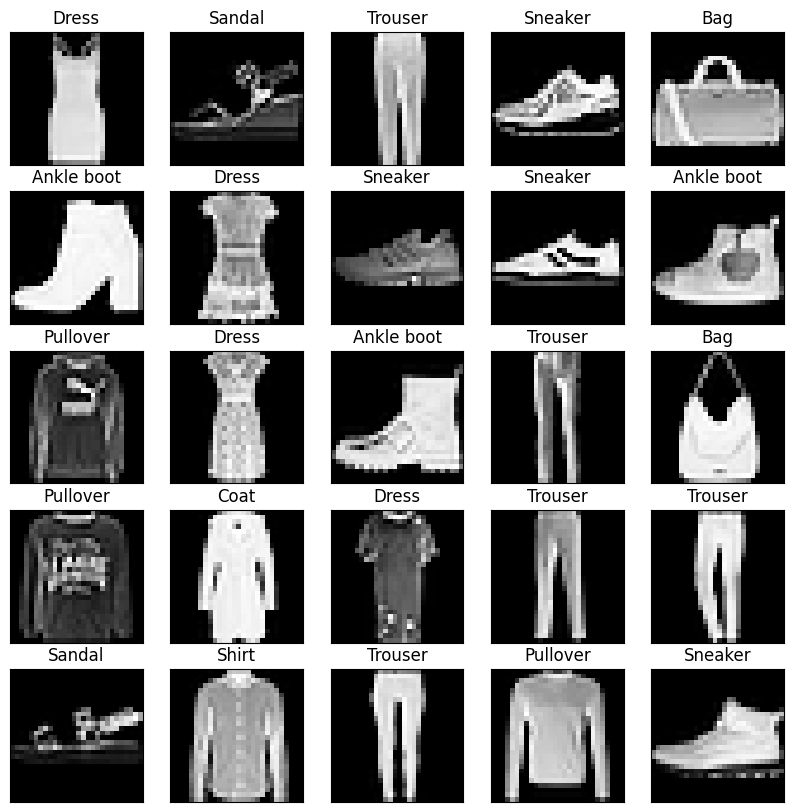

In [4]:
# Fashion-MNIST 데이터셋에서 25장 이미지 샘플을 출력
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# 학습 데이터 다운로드
fmnist_data = FashionMNIST(root="/data",
                              train=True, download=True,
                              transform= transforms.ToTensor())
# 학습 데이터 클래스
fmnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
print("데이터의 개수:", len(fmnist_data))

n_image = 25 # 표시할 이미지의 개수
fmnist_loader = DataLoader(fmnist_data, batch_size=n_image,shuffle=True)
dataiter = iter(fmnist_loader)  # 이터레이터
images, labels = next(dataiter)  # 배치 이터레이터의 첫번째 이미지와 레이블을 꺼낸다.

img_size = 28
plt.figure(figsize=(10,10))
for i in range(n_image):
   ax = plt.subplot(5,5,i+1)
   ax.imshow(images[i].view(img_size, img_size), cmap='Greys_r')
   label = fmnist_classes[labels[i]]
   ax.set_title(label)
   ax.get_xaxis().set_visible(False)
   ax.get_yaxis().set_visible(False)

plt.show()

#### 학습용 데이터 전처리
* 이미지 데이터를 RNN에 적합한 형태로 전처리
* 14개의 행을 넣음
* 15행부터 28행까지의 행을 정답인 correct_data에 담기

In [5]:
import torch
from torch.utils.data import TensorDataset

n_time = 14 # 초기 입력되는 시각(행) 개수
n_in = img_size # 입력층의 뉴런 개수
n_mid = 256 # 중간층의 뉴런 개수
n_out = img_size # 출력층의 뉴런 개수
n_sample_in_img = img_size-n_time # 1장의 이미지 데이터에서 출력해야하는 샘플 개수

dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader) # 이터레이터
train_imgs, labels = next(dataiter) # 이터레이터에서 학습 이미지와 레이블 꺼내기
train_imgs = train_imgs.view(-1, img_size, img_size)

n_sample = len(train_imgs) * n_sample_in_img # 샘플 개수

input_data = torch.zeros((n_sample, n_time, n_in)) # 입력
correct_data = torch.zeros((n_sample, n_out)) # 레이블
for i in range(len(train_imgs)):
   for j in range(n_sample_in_img):
      sample_id = i*n_sample_in_img + j
      input_data[sample_id] = train_imgs[i, j: j+n_time]
      correct_data[sample_id] = train_imgs[i, j+n_time]

dataset = TensorDataset(input_data, correct_data) # 데이터셋 설정
train_loader = DataLoader(dataset, batch_size=128, shuffle=True) # 데이터로더 설정

#### 테스트 데이터 전처리
* 생성된 이미지를 검증하는데 사용하는 데이터를 전처리

In [6]:
n_disp = 10 # 생성하고 출력할 이미지 개수

disp_data = FashionMNIST(root="/data",
                                 train=False, download=True,
                                 transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader) # 이터레이터
disp_imgs, labels = next(dataiter) # 이터레이터에서 이미지와 레이블을 꺼낸다.
disp_imgs = disp_imgs.view(-1, img_size, img_size)

#### 모델 구축하기
* n.Module()클래스를 상속받는 클래스로 순환 신경망 모델을 구축
* LSTM레이어를 사용

In [15]:
import torch.nn as nn

class Net(nn.Module):
   def __init__(self):
      super().__init__()
      self.rnn = nn.LSTM(    # LSTM 레이어
         input_size=n_in,       # 입력층의 뉴런 개수
         hidden_size=n_mid, # 중간층의 뉴런 개수
         batch_first=True)     
         # True이면, (배치, 시퀀스, 피처)의 텐서 구조를 취급하며, False인 경우 (시퀀스, 배치, 피처)
         # 여기서는 (배치 크기, 시각 개수, 입력층의 뉴런 개수)
      self.fc = nn.Linear(n_mid, n_out)

   def forward(self, x):
      # y_rnn: 모든 시각의 출력
      # h: 중간층의 최종 시각의 값
      # c: 기억 셀
      y_rnn, (h,c) = self.rnn(x, None)
      y = self.fc(y_rnn[:, -1, :]) # y는 최종 시각의 출력
      return y

net = Net()
net.cuda()
print(net)

AssertionError: Torch not compiled with CUDA enabled

#### 이미지 생성 함수 만들기
* 원본 이미지 disp_imgs와 윗 부분으로 아랫부분을 생성한 gen_imgs를 출력해주는 함수
* disp_imgs는 테스트 데이터를 사용
* 이미지 생성 초기에는 14개 행의 데이터를 사용
* 다음부터는 새로운 행을 포함한 최근의 시계열로만 다음 행을 생성

In [13]:
def generate_images():
   # 생성 초기에 사용할 원본 이미지
   print("Original:")
   plt.figure(figsize=(20,2))
   for i in range(n_disp):
      ax = plt.subplot(1, n_disp, i+1)
      ax.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
   plt.show()

   # 생성해줄 아랫부분 이미지
   print("Generated:")
   net.eval() # 평가 모드
   gen_imgs = disp_imgs.clone()
   plt.figure(figsize=(20,2))
   for i in range(n_disp):
      for j in range(n_sample_in_img):
         x = gen_imgs[i,j:j+n_time].view(1, n_time, img_size)
         x = x.cuda() # GPU 사용
         gen_imgs[i, j+n_time] = net(x)[0]
      ax = plt.subplot(1, n_disp, i+1)
      ax.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
   plt.show()

#### 학습
* 순환 신경망 모델을 학습시켜봅시다. DataLoader를 사용해 미니 배치 학습으로 학습, 평가

In [14]:
from torch import optim

loss_fnc = nn.MSELoss()

optimizer = optim.Adam(net.parameters())

record_loss_train = []

epochs = 30
for i in range(epochs):
   net.train() # 훈련 모드
   loss_train = 0
   for j, (x, t) in enumerate(train_loader):
      x, t = x.cuda(), t.cuda()
      y = net(x)
      loss = loss_fnc(y, t)
      loss_train += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
   loss_train /= j+1
   record_loss_train.append(loss_train)

   if i % 5 == 0 or i == epochs-1:
      print("Epoch:", i, "Loss_Train:", loss_train)
      generate_images()

AssertionError: Torch not compiled with CUDA enabled

#### 손실 값 시각화해보기

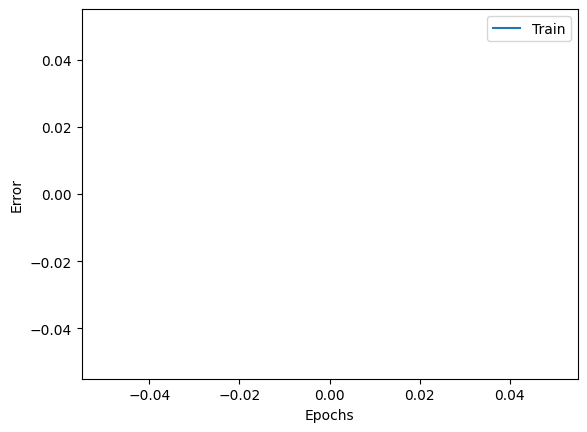

In [16]:
plt.plot(range(len(record_loss_train)), record_loss_train, label= "Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

#### GRU 레이어를 가지고 새롭게 학습

In [17]:
# 학습용 데이터 전처리
img_size = 28
n_time = 14
# 테스트용 데이터 준비
n_disp = 10
# GRU를 사용한 모델 구축
import torch.nn as nn

class Net(nn.Module):
   def __init__(self):
      super().__init__()
      self.gru = nn.GRU(    
         input_size=n_in,       
         hidden_size=n_mid, 
         batch_first=True)     
      self.fc = nn.Linear(n_mid, n_out)

   def forward(self, x):
      y_gru, h = self.gru(x, None)
      y = self.fc(y_gru[:, -1, :]) 
      return y

net = Net()
net.cuda()

# 이미지 생성 함수 정의
def generate_images():
   # 생성 초기에 사용할 원본 이미지
   print("Original:")
   plt.figure(figsize=(20,2))
   for i in range(n_disp):
      ax = plt.subplot(1, n_disp, i+1)
      ax.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
   plt.show()

   # 생성해줄 아랫부분 이미지
   print("Generated:")
   net.eval() # 평가 모드
   gen_imgs = disp_imgs.clone()
   plt.figure(figsize=(20,2))
   for i in range(n_disp):
      for j in range(n_sample_in_img):
         x = gen_imgs[i,j:j+n_time].view(1, n_time, img_size)
         x = x.cuda() # GPU 사용
         gen_imgs[i, j+n_time] = net(x)[0]
      ax = plt.subplot(1, n_disp, i+1)
      ax.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
   plt.show()

AssertionError: Torch not compiled with CUDA enabled

In [18]:
# 학습
from torch import optim

loss_fnc = nn.MSELoss()

optimizer = optim.Adam(net.parameters())

record_loss_train = []

epochs = 10
for i in range(epochs):
   net.train() # 훈련 모드
   loss_train = 0
   for j, (x, t) in enumerate(train_loader):
      x, t = x.cuda(), t.cuda()
      y = net(x)
      loss = loss_fnc(y, t)
      loss_train += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
   loss_train /= j+1
   record_loss_train.append(loss_train)

   if i % 5 == 0 or i == epochs-1:
      print("Epoch:", i, "Loss_Train:", loss_train)
      generate_images()

AssertionError: Torch not compiled with CUDA enabled

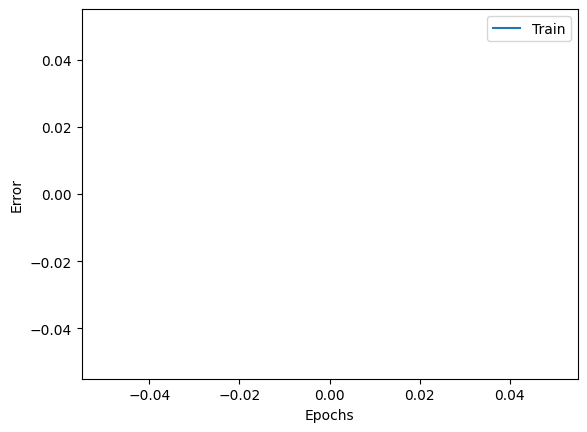

In [19]:
# 손실 값 시각화
plt.plot(range(len(record_loss_train)), record_loss_train, label= "Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()